# Extract Whistles From Box 2 Box

We need to extract whistles played through the ocean and recorded by a box.

## Basic Idea
Use the original file to find gaps.
Align the recorded file to the original file (manually).
Find all gaps that are large enough in the original file:
    $$(gap_{i, start}, gap_{i, stop})$$.
    
Use the gaps to find whistles. Since the extractor is not perfect, we classify each region using the trace and
a nearest neighbor based solution.

In [14]:
import os
import matplotlib.pyplot as plt
import numpy as np

from mimic_utils.spectrogram import *
from mimic_utils.whistle_tracer import *
from mimic_utils.params import * 
from scipy.io import wavfile
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw


## The algorithms to extract the audio

Loading Classifier Template: sar.wav
Loading Classifier Template: sca.wav
Loading Classifier Template: gra.wav
Loading Classifier Template: den.wav
Loading Classifier Template: rop.wav


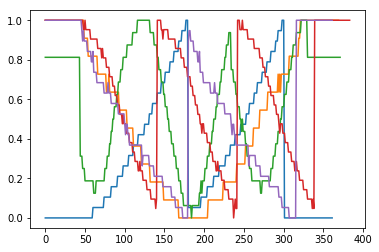

In [17]:
def wtrace(audio):    
    spec = fwd_spectrogram(audio, FFT_WIN, FFT_STEP)
    whistle_trace, _  = trace(spec, TRACE_RAD, SMOOTH_ENT)
    whistle_trace = whistle_trace[:-1]
    whistle_trace = whistle_trace[whistle_trace > 0.0]
    hi  = np.max(whistle_trace)
    lo = np.min(whistle_trace)
    return (whistle_trace - lo) / (hi - lo)


class Classifier:
    
    def __init__(self, folder):
        self.templates = {}
        for filename in os.listdir(folder):
            if filename.endswith(".wav"):
                print("Loading Classifier Template: {}".format(filename))
                basename = filename.split("/")[-1].replace(".wav", "")
                _, data = wavfile.read("{}/{}".format(folder, filename))
                self.templates[basename] = wtrace(data[:, 0])
                
    def nn(self, trace):
        min_label = -1
        min_dist  = float('inf') 
        for label, template in self.templates.items():
            dist, path = fastdtw(trace, template, dist=euclidean)
            print("{} {}", label, dist)
            if dist < min_dist:
                min_dist = dist
                min_label = label
        print("Min Dist: {} Min Label: {}".format(min_dist, min_label))
        return min_label
namer = Classifier("originals/")

for label,t in namer.templates.items():
    plt.plot(t)
plt.show()

## Extract the 00 variations

00_chat1-2019-06-23T123304-192k
Using templates


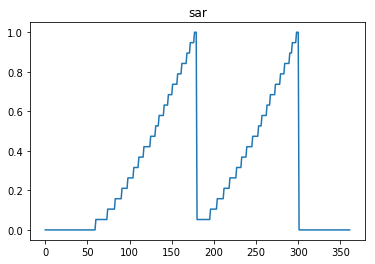

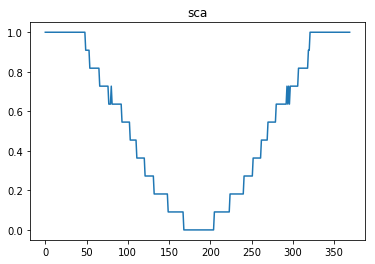

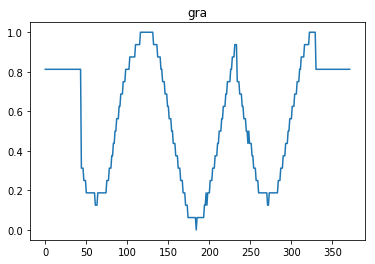

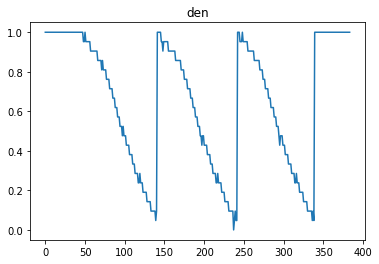

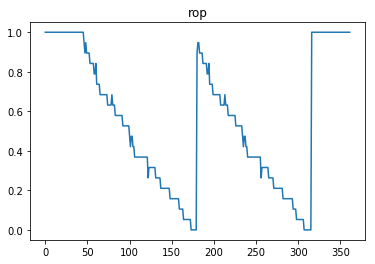

Searching gaps
STOP 5.208333333333334e-05 1.9519947916666667 1.9519427083333334 %done 0.5673610251376859 0
STOP 3.6984427083333333 4.573083333333333 0.874640625 %done 1.3291988580690497 1
STOP 6.28975 7.156640625 0.866890625 %done 2.080127969027586 2
STOP 8.855036458333334 9.702692708333334 0.84765625 %done 2.8201559272070034 3
STOP 11.377479166666667 12.253765625 0.8762864583333333 %done 3.5616432259334383 4
STOP 13.948526041666666 14.753880208333333 0.8053541666666667 %done 4.288319126410894 5
STOP 16.018739583333332 16.755416666666665 0.7366770833333334 %done 4.8700797856598115 6
STOP 17.763796875 18.48821875 0.724421875 %done 5.373730907352252 7
STOP 19.481322916666667 20.209307291666665 0.727984375 %done 5.873977405714566 8
STOP 21.102927083333334 21.81696875 0.7140416666666667 %done 6.341255523959723 9
STOP 22.697645833333333 25.342401041666665 2.644755208333333 %done 7.365947232970729 10
STOP 27.081630208333333 27.963026041666666 0.8813958333333334 %done 8.12765033425408 11
STOP

In [ ]:
def extract_all(original, recorded, output, classifier, border = 30000, min_gap_size = 100000, th = 0.2):
    basename = recorded.split("/")[-1].replace(".wav", "")
    print(basename)
    _,  data_original = wavfile.read(original)
    fs, data_box      = wavfile.read(recorded)
    data = (data_original[:, 0] + 32768) / (32768 + 32767)    

    last_sample = 0
    start_i = 0    
    gaps = []
    
    print("Using templates")
    for label, t in classifier.templates.items():
        plt.title(label)
        plt.plot(t)
        plt.show()
    
    print("Searching gaps")
    n = len(data_original)
    for i in range(10, n):
        sample = np.sum(data[i - 10:i]) / 10        
        if sample < th and last_sample >= th and i - start_i > min_gap_size:
            print("STOP {} {} {} %done {} {}".format(start_i / fs, i / fs, (i - start_i) / fs, (i / n) * 100, len(gaps)))
            gaps.append([start_i, i])        
        if sample >= th and last_sample < th:
            start_i = i
        last_sample = sample

    print("Processing gaps")
    for i in range(1, len(gaps)):  
        _, start = gaps[i - 1]
        stop, _  = gaps[i]
        print("Tracing {} {}".format(start / fs, stop / fs))
        trace = wtrace(data_original[start - border: stop + border, 0])
        print("Traced!")
        name = classifier.nn(trace)        
        filename = '{}/{}_{}_{}.wav'.format(output, name, basename, start)
        print("DETECTED: ", filename)
        wavfile.write(filename, fs, data_box[start - border: stop + border, 0])

output     = "00" 
original   = '/Users/daniel.kohlsdorf/Desktop/00-all-whistles-2019-synth--04--18.wav'
recorded   = '/Users/daniel.kohlsdorf/Desktop/00_chat1-2019-06-23T123304-192k.wav'
extract_all(original, recorded, output, namer)